In [1]:
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install neattext
import neattext.functions as nfx
import matplotlib.pyplot as plt
import plotly.express as plx
from sklearn.metrics import classification_report
import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
#from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('Suicide_Detection.csv')
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [3]:
data['class'].value_counts()

suicide        116037
non-suicide    116037
Name: class, dtype: int64

In [4]:
data['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

In [5]:
train_data,test_data=train_test_split(data,test_size=0.3,random_state=10)

In [6]:
train_data['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

In [7]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
#         sent=nfx.remove_shortwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [8]:
cleaned_train_text,train_text_length=clean_text(train_data.text)
cleaned_test_text,test_text_length=clean_text(test_data.text)

100%|█████████████████████████████████████████████████████████████████████████| 69623/69623 [00:05<00:00, 11870.92it/s]


In [9]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

In [10]:
word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)

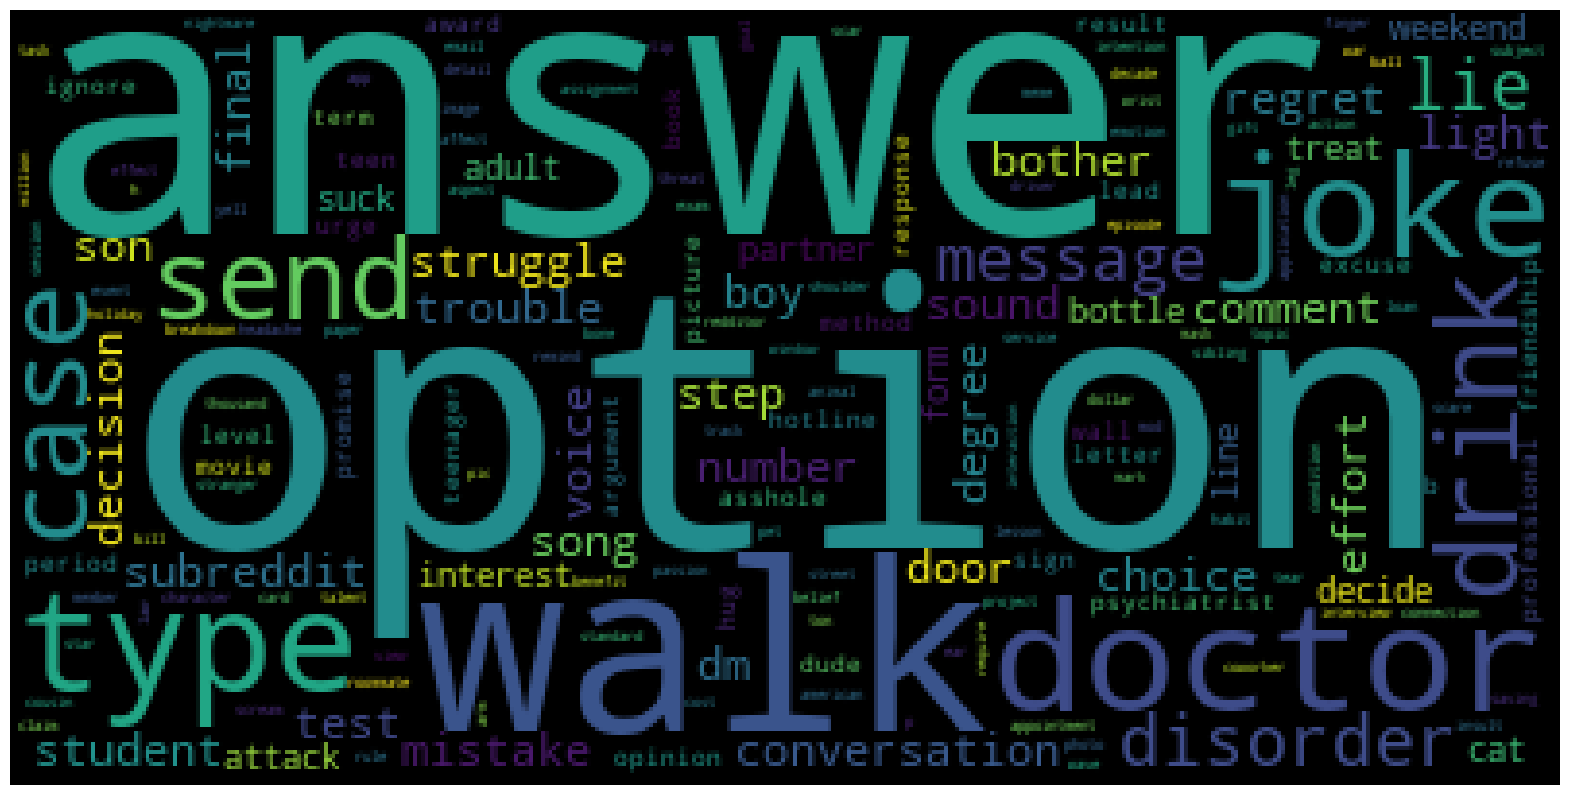

In [11]:
feature_names=word_freq['word'].values
wc=WordCloud(max_words=400)
wc.generate(' '.join(word for word in feature_names[500:3500] ))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)

In [19]:
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=50)


test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=50)

In [20]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

In [21]:
print('Indexing word vectors.')
embeddings_index = {}
with open('glove.6B.300d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:],dtype='float32')
        embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [22]:
v=len(tokenizer.word_index)

embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

In [23]:
reducelr=ReduceLROnPlateau(patience=3)

In [24]:
model=Sequential()
model.add(Input(shape=(50,)))
model.add(Embedding(v+1,300,weights=[embedding_matrix],trainable=False))
model.add(LSTM(20,return_sequences=True))
model.add(GlobalMaxPooling1D())
#     model.add(Dropout(0.3))
model.add(Dense(256,activation='relu'))
#     model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])

In [25]:
r=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=30,batch_size=256,callbacks=[reducelr])

Epoch 1/30
635/635 [==============================] - 59s 89ms/step - loss: 0.3641 - accuracy: 0.8430 - val_loss: 0.2728 - val_accuracy: 0.8910 - lr: 0.1000
Epoch 2/30
635/635 [==============================] - 56s 89ms/step - loss: 0.2656 - accuracy: 0.8930 - val_loss: 0.2543 - val_accuracy: 0.8985 - lr: 0.1000
Epoch 3/30
635/635 [==============================] - 57s 89ms/step - loss: 0.2477 - accuracy: 0.9012 - val_loss: 0.2456 - val_accuracy: 0.9024 - lr: 0.1000
Epoch 4/30
635/635 [==============================] - 56s 88ms/step - loss: 0.2344 - accuracy: 0.9074 - val_loss: 0.2397 - val_accuracy: 0.9050 - lr: 0.1000
Epoch 5/30
635/635 [==============================] - 53s 83ms/step - loss: 0.2252 - accuracy: 0.9110 - val_loss: 0.2251 - val_accuracy: 0.9120 - lr: 0.1000
Epoch 6/30
635/635 [==============================] - 55s 86ms/step - loss: 0.2179 - accuracy: 0.9147 - val_loss: 0.2214 - val_accuracy: 0.9136 - lr: 0.1000
Epoch 7/30
635/635 [==============================] - 56s 

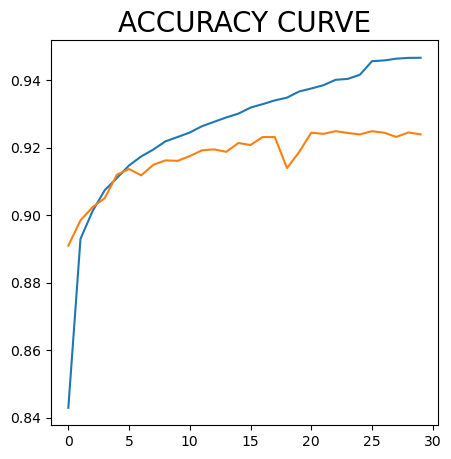

In [26]:
plt.figure(figsize=(5,5))
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()

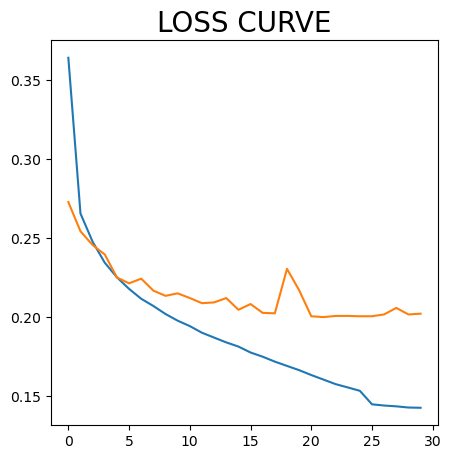

In [27]:
plt.figure(figsize=(5,5))
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()

In [28]:
model.save('sohila.h5')

In [31]:
def detectSuicide(text):
    cleaned_text, length = clean_text(text)
    tokens = tokenizer.texts_to_sequences(cleaned_text)
    paded = pad_sequences(tokens,maxlen=50)
    if model.predict([paded]) >=0.55:
        print("contains suicidal thoughts")
    else:
        print("Doesn't contains suicidal thoughts")

In [32]:
detectSuicide([""""I've been struggling with depression for a 
          long time now but I just my first severe instance 
          of depersonalization and it scared me so badly i m not 
          even entirely sure why but something about the fact that 
          i just spent over an hour lying on the floor feeling like 
          my body didn t really belong to me and i might not be real 
          is so extremely unsettling to me i feel more mentally"""])

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


1/1 [==============================] - 1s 908ms/step
contains suicidal thoughts


In [35]:
detectSuicide(["I feel like dying as everyone make me feel like this"])

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step
contains suicidal thoughts
